# POS-tagger и NER

Задание 1.
* Написать теггер на данных с русским языком
проверить UnigramTagger, BigramTagger, TrigramTagger и их комбинации

* написать свой теггер как на занятии, попробовать разные векторайзеры, добавить знание не только букв но и слов

* сравнить все реализованные методы, сделать выводы  


Задание 2.
* Проверить, насколько хорошо работает NER  
  Данные брать из http://www.labinform.ru/pub/named_entities/

* проверить NER из nltk/spacy/deeppavlov.
* написать свой NER, попробовать разные подходы.
  - передаём в сетку токен и его соседей.
  - передаём в сетку только токен.
  - свой вариант.
* сравнить свои реализованные подходы на качество — вывести precision/recall/f1_score.


In [ ]:
!pip install -q pyconll
!pip install -q corus
!pip install -q razdel
!pip install -U spacy

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import UnigramTagger, BigramTagger, TrigramTagger, DefaultTagger
import corus
import pyconll
from corus import load_ne5
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, \
                                            TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection, preprocessing, linear_model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from razdel import tokenize
import spacy
from spacy import displacy

import tensorflow as tf
from keras import Sequential
from keras.layers import Dense, Embedding, GlobalAveragePooling1D, \
                         GlobalMaxPooling1D, Conv1D, GRU, LSTM, Dropout, Input
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [3]:
!wget https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train-a.conllu
!wget https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train-b.conllu
!wget https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train-c.conllu
!wget https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-dev.conllu

--2023-08-29 13:29:28--  https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train-a.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40736581 (39M) [text/plain]
Saving to: ‘ru_syntagrus-ud-train-a.conllu’

ru_syntagrus-ud-tra 100%[===================>]  38.85M  --.-KB/s    in 0.1s    

2023-08-29 13:29:31 (294 MB/s) - ‘ru_syntagrus-ud-train-a.conllu’ saved [40736581/40736581]

--2023-08-29 13:29:31--  https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train-b.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185

In [4]:
full_train = pyconll.load_from_file('ru_syntagrus-ud-train-a.conllu')
full_train_b = pyconll.load_from_file('ru_syntagrus-ud-train-b.conllu')
full_train_c = pyconll.load_from_file('ru_syntagrus-ud-train-c.conllu')

full_train.extend([*full_train_b, *full_train_c])

full_test = pyconll.load_from_file('ru_syntagrus-ud-dev.conllu')

In [5]:
fdata_train = []
for sent in full_train[:]:
    fdata_train.append([(token.form, token.upos) for token in sent])

fdata_test = []
for sent in full_test[:]:
    fdata_test.append([(token.form, token.upos) for token in sent])

fdata_sent_test = []
for sent in full_test[:]:
    fdata_sent_test.append([token.form for token in sent])

In [6]:
comparing_list = []

In [7]:
default_tagger = DefaultTagger('NOUN')

display(default_tagger.evaluate(fdata_test))

comparing_list.append(('default_tagger', default_tagger.evaluate(fdata_test)))

0.23593983983332248

In [8]:
unigram_tagger = UnigramTagger(fdata_train)

display(unigram_tagger.evaluate(fdata_test))

comparing_list.append(('unigram_tagger', unigram_tagger.evaluate(fdata_test)))

0.8782863467673677

In [9]:
bigram_tagger = BigramTagger(fdata_train, backoff=unigram_tagger)

display(bigram_tagger.evaluate(fdata_test))

comparing_list.append(('bigram_tagger', bigram_tagger.evaluate(fdata_test)))

0.8839768214076438

In [10]:
trigram_tagger = TrigramTagger(fdata_train, backoff=bigram_tagger)

display(trigram_tagger.evaluate(fdata_test))

comparing_list.append(('trigram_tagger', trigram_tagger.evaluate(fdata_test)))

0.8830522820496126

**Tagger combination

In [11]:
def backoff_tagger(train_sents, tagger_classes, backoff=None):
    for cls in tagger_classes:
        backoff = cls(train_sents, backoff=backoff)
    return backoff

backoff = DefaultTagger('NOUN')

In [12]:
tag = backoff_tagger(fdata_train,
                     [UnigramTagger, BigramTagger, TrigramTagger],
                     backoff=backoff)

display(tag.evaluate(fdata_test))

comparing_list.append(('U_B_T', tag.evaluate(fdata_test)))

0.9119799466111075

In [13]:
tag = backoff_tagger(fdata_train,
                     [UnigramTagger, BigramTagger],
                     backoff=backoff)

display(tag.evaluate(fdata_test))

comparing_list.append(('U_B', tag.evaluate(fdata_test)))

0.9118822840028648

In [14]:
tag = backoff_tagger(fdata_train,
                     [BigramTagger, TrigramTagger],
                     backoff=backoff)

display(tag.evaluate(fdata_test))

comparing_list.append(('B_T', tag.evaluate(fdata_test)))

0.8606680122403803

In [15]:
tag = backoff_tagger(fdata_train,
                     [UnigramTagger, TrigramTagger],
                     backoff=backoff)

display(tag.evaluate(fdata_test))

comparing_list.append(('U_T', tag.evaluate(fdata_test)))

0.9119213490461618

In [16]:
train_tok = []
train_label = []
for sent in fdata_train[:]:
    for tok in sent:
        if (tok[0] is None) or (tok[1] is None):
            continue
        train_tok.append(tok[0])
        train_label.append('NO_TAG' if tok[1] is None else tok[1])

test_tok = []
test_label = []
for sent in fdata_test[:]:
    for tok in sent:
        if (tok[0] is None) or (tok[1] is None):
            continue
        test_tok.append(tok[0])
        test_label.append('NO_TAG' if tok[1] is None else tok[1])

In [17]:
le = LabelEncoder()
train_enc_labels = le.fit_transform(train_label)
test_enc_labels = le.transform(test_label)

In [18]:
cvtr = CountVectorizer(ngram_range=(1, 3), analyzer='char')

X_train = cvtr.fit_transform(train_tok)
X_test = cvtr.transform(test_tok)

lr = LogisticRegression(random_state=13, n_jobs=8, max_iter=20)
lr.fit(X_train, train_enc_labels)

pred = lr.predict(X_test)
display(accuracy_score(test_enc_labels, pred))

comparing_list.append(('count_vectorizer', accuracy_score(test_enc_labels, pred)))

0.8514267079732594

In [19]:
hvtr = HashingVectorizer(ngram_range=(1, 3), analyzer='char', n_features=100)

X_train = hvtr.fit_transform(train_tok)
X_test = hvtr.transform(test_tok)

lr = LogisticRegression(random_state=13, n_jobs=8, max_iter=20)
lr.fit(X_train, train_enc_labels)

pred = lr.predict(X_test)
display(accuracy_score(test_enc_labels, pred))

comparing_list.append(('hashing_vectorizer', accuracy_score(test_enc_labels, pred)))

0.6735626936246535

In [20]:
tfvtr = TfidfVectorizer(ngram_range=(1, 3), analyzer='char')

X_train = tfvtr.fit_transform(train_tok)
X_test = tfvtr.transform(test_tok)

lr = LogisticRegression(random_state=13, n_jobs=8, max_iter=20)
lr.fit(X_train, train_enc_labels)

pred = lr.predict(X_test)
display(accuracy_score(test_enc_labels, pred))

comparing_list.append(('tfidf_vectorizer', accuracy_score(test_enc_labels, pred)))

0.8065416598728192

In [21]:
comparing_list

[('default_tagger', 0.23593983983332248),
 ('unigram_tagger', 0.8782863467673677),
 ('bigram_tagger', 0.8839768214076438),
 ('trigram_tagger', 0.8830522820496126),
 ('U_B_T', 0.9119799466111075),
 ('U_B', 0.9118822840028648),
 ('B_T', 0.8606680122403803),
 ('U_T', 0.9119213490461618),
 ('count_vectorizer', 0.8514267079732594),
 ('hashing_vectorizer', 0.6735626936246535),
 ('tfidf_vectorizer', 0.8065416598728192)]

In [22]:
pd.DataFrame(comparing_list, columns=['tagger', 'accuracy']).sort_values(by='accuracy', ascending=False)

,tagger,accuracy
4,U_B_T,0.911980
7,U_T,0.911921
5,U_B,0.911882
2,bigram_tagger,0.883977
3,trigram_tagger,0.883052
1,unigram_tagger,0.878286
6,B_T,0.860668
8,count_vectorizer,0.851427
10,tfidf_vectorizer,0.806542
9,hashing_vectorizer,0.673563


# Задание 2

In [23]:
!wget http://www.labinform.ru/pub/named_entities/collection5.zip

--2023-08-29 13:33:58--  http://www.labinform.ru/pub/named_entities/collection5.zip
Resolving www.labinform.ru (www.labinform.ru)... 95.181.230.181
Connecting to www.labinform.ru (www.labinform.ru)|95.181.230.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1899530 (1.8M) [application/zip]
Saving to: ‘collection5.zip’

collection5.zip     100%[===================>]   1.81M   927KB/s    in 2.0s    

2023-08-29 13:34:01 (927 KB/s) - ‘collection5.zip’ saved [1899530/1899530]



In [ ]:
!unzip collection5.zip

In [25]:
records = load_ne5('Collection5')
next(records)

Ne5Markup(
    id='084',
    text='Cара Пэйлин посоветовала Обаме объявить войну Ирану\r\nБывший губернатор Аляски и экс-кандидат в вице-президенты США Сара Пэйлин посоветовала Бараку Обаме объявить войну Ирану, пишет The Los Angeles Times. По мнению Пэйлин, только такая мера позволит президенту США укрепить свои позиции и заручиться поддержкой избирателей на следующих выборах главы государства.\r\n\r\nТакое заявление Пэйлин сделала в эфире телепрограммы "Fox News Sunday". Экс-губернатор Аляски работает на канале Fox News новостным и аналитическим комментатором.\r\n\r\nПэйлин также предложила Обаме оказать полную поддержку Израилю в арабо-израильском конфликте, отмечает Press TV. По ее словам, именно упор на силовую политику позволит Обаме продержаться до следующих выборов.\r\n\r\nОна отметила, что сомневается в победе Обамы в том случае, если бы выборы состоялись прямо сейчас. Также Пэйлин посетовала, что окружение Обамы дает президенту "неправильные советы". В частности, она призвала

In [26]:
words_docs = []
for ix, rec in enumerate(records):
    words = []
    for token in tokenize(rec.text):
        type_ent = 'OUT'
        for ent in rec.spans:
            if (token.start >= ent.start) and (token.stop <= ent.stop):
                type_ent = ent.type
                break
        words.append([token.text, type_ent])
    words_docs.extend(words)

In [27]:
df_words = pd.DataFrame(words_docs, columns=['word', 'tag'])

In [28]:
df_words.shape

(265306, 2)

In [29]:
df_words.head(4)

,word,tag
0,Государственные,OUT
1,деятели,OUT
2,",",OUT
3,погибшие,OUT


In [30]:
df_words['tag'].value_counts()

OUT         219090
PER          21180
ORG          13651
LOC           4566
GEOPOLIT      4348
MEDIA         2471
Name: tag, dtype: int64

In [31]:
records = load_ne5('Collection5')
next(records).text
next(records).text
next(records).text
next(records).text
next(records).text
article = next(records).text
article

'В.Колокольцев переназначен на должность главы ГУВД по Москве, а Р.Алханов - главы МВД Чечни.\r\n\r\nПрезидент России Дмитрий Медведев подписал указ, которым переназначил на должность руководителя Главного управления Министерства внутренних дел РФ по Москве Владимира Колокольцева и на должность министра внутренних дел Чеченской Республики Руслана Алханова. Как сообщает пресс-служба главы Российского государства, этим документам и В.Колокольцеву, и Р.Алханову присваиваются звания генерал-лейтенантов полиции, ранее оба были генерал-лейтенантами милиции.'

In [32]:
nltk.download('words')
nltk.download('maxent_ne_chunker')
nltk.download('names')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [33]:
words5 = list(df_words.word)

In [34]:
data5_tag = nltk.pos_tag(words5[:50000])

In [35]:
{(' '.join(c[0] for c in chunk), chunk.label() ) for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(article))) if hasattr(chunk, 'label') }

{('МВД Чечни', 'ORGANIZATION'),
 ('Москве Владимира Колокольцева', 'PERSON'),
 ('России Дмитрий Медведев', 'PERSON'),
 ('Российского', 'PERSON'),
 ('Руслана Алханова', 'PERSON')}

In [ ]:
!python -m spacy download ru_core_news_sm

In [37]:
nlp = spacy.load("ru_core_news_sm")
spacy_article = nlp(article)
displacy.render(spacy_article, jupyter=True, style='ent')

# Deeppavlov

In [38]:
!pip install -q deeppavlov

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.3/487.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.4/222.4 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 80.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.9 MB/s eta 0:00:00


In [ ]:
!python -m deeppavlov install ner_rus_bert

In [40]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4133807 sha256=accae8135cfa943ce69558304aecaae838278de4ec78e115c85aa1414999444c
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [41]:
import deeppavlov
from deeppavlov import configs, build_model

In [42]:
config_path = configs.ner.ner_rus_bert
deeppavlov_ner = build_model(config_path, download=True)

2023-08-29 13:40:05.20 INFO in 'deeppavlov.core.data.utils'['utils'] at line 95: Downloading from http://files.deeppavlov.ai/v1/ner/ner_rus_bert_torch_new.tar.gz to /root/.deeppavlov/models/ner_rus_bert_torch_new.tar.gz
INFO:deeppavlov.core.data.utils:Downloading from http://files.deeppavlov.ai/v1/ner/ner_rus_bert_torch_new.tar.gz to /root/.deeppavlov/models/ner_rus_bert_torch_new.tar.gz
100%|██████████| 1.44G/1.44G [01:28<00:00, 16.2MB/s]
2023-08-29 13:41:35.99 INFO in 'deeppavlov.core.data.utils'['utils'] at line 276: Extracting /root/.deeppavlov/models/ner_rus_bert_torch_new.tar.gz archive into /root/.deeppavlov/models/ner_rus_bert_torch
INFO:deeppavlov.core.data.utils:Extracting /root/.deeppavlov/models/ner_rus_bert_torch_new.tar.gz archive into /root/.deeppavlov/models/ner_rus_bert_torch


Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initializ

In [43]:
rus_document = 'С.Собянин провел ряд перестановок в московском правительствеВ частности, градоначальник назначил заместителем префекта Центрального административного округа Москвы Владимира Старкова.'
deeppavlov_ner([rus_document])

[[['С',
   '.',
   'Собянин',
   'провел',
   'ряд',
   'перестановок',
   'в',
   'московском',
   'правительствеВ',
   'частности',
   ',',
   'градоначальник',
   'назначил',
   'заместителем',
   'префекта',
   'Центрального',
   'административного',
   'округа',
   'Москвы',
   'Владимира',
   'Старкова',
   '.']],
 [['B-PER',
   'I-PER',
   'I-PER',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B-LOC',
   'I-LOC',
   'I-LOC',
   'B-LOC',
   'B-PER',
   'I-PER',
   'O']]]

# Own NER

In [44]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df_words['word'], df_words['tag'])

encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [45]:
train_x.apply(len).max(axis=0)

55

In [46]:
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y))
valid_data = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))

train_data = train_data.batch(16)
valid_data = valid_data.batch(16)

In [47]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)

In [48]:
def custom_standardization(input_data):
    return input_data

vocab_size = 30000
seq_len = 10

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    #ngrams=(1, 3),
    output_sequence_length=seq_len)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_data = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_data)

In [49]:
len(vectorize_layer.get_vocabulary())

29939

In [50]:
embedding_dim = 64

class modelNER(tf.keras.Model):
    def __init__(self):
        super(modelNER, self).__init__()
        self.emb = Embedding(vocab_size, embedding_dim)
        self.gPool = GlobalMaxPooling1D()
        self.fc1 = Dense(300, activation='relu')
        self.fc2 = Dense(50, activation='relu')
        self.fc3 = Dense(6, activation='softmax')

    def call(self, x):
        x = vectorize_layer(x)
        x = self.emb(x)
        pool_x = self.gPool(x)

        fc_x = self.fc1(pool_x)
        fc_x = self.fc2(fc_x)

        concat_x = tf.concat([pool_x, fc_x], axis=1)
        prob = self.fc3(concat_x)
        return prob

In [51]:
mmodel = modelNER()

In [52]:
mmodel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [53]:
mmodel.fit(train_data, validation_data=valid_data, epochs=3)

Epoch 1/3
12437/12437 [==============================] - 83s 6ms/step - loss: 0.2935 - accuracy: 0.9144 - val_loss: 0.2096 - val_accuracy: 0.9385
Epoch 2/3
12437/12437 [==============================] - 73s 6ms/step - loss: 0.1244 - accuracy: 0.9627 - val_loss: 0.2055 - val_accuracy: 0.9412
Epoch 3/3
12437/12437 [==============================] - 76s 6ms/step - loss: 0.1091 - accuracy: 0.9658 - val_loss: 0.2275 - val_accuracy: 0.9403


In [54]:
preds = mmodel.predict(valid_x)
preds = np.argmax(preds,axis=1)

2073/2073 [==============================] - 7s 3ms/step


In [55]:
print(classification_report(valid_y, preds))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1052
           1       0.84      0.80      0.82      1107
           2       0.94      0.76      0.84       608
           3       0.92      0.51      0.65      3485
           4       0.94      1.00      0.97     54768
           5       0.99      0.71      0.83      5307

    accuracy                           0.94     66327
   macro avg       0.92      0.78      0.83     66327
weighted avg       0.94      0.94      0.93     66327



In [56]:
classes = encoder.classes_
classes

array(['GEOPOLIT', 'LOC', 'MEDIA', 'ORG', 'OUT', 'PER'], dtype=object)

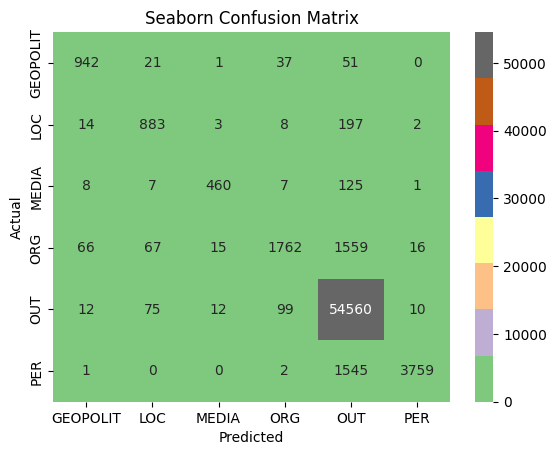

In [57]:
cm = confusion_matrix(valid_y, preds)
ax = sns.heatmap(cm, annot=True, fmt='g', cmap="Accent")

ax.set_title('Seaborn Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

## For the Tick Labels, the labels should be in Alphabetical order
ax.xaxis.set_ticklabels(['GEOPOLIT', 'LOC', 'MEDIA', 'ORG', 'OUT', 'PER'])
ax.yaxis.set_ticklabels(['GEOPOLIT', 'LOC', 'MEDIA', 'ORG', 'OUT', 'PER'])

plt.show()

In [58]:
# добавим биграмы
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    ngrams=(1, 2),
    output_sequence_length=seq_len)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_data = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_data)
mmodel_bi = modelNER()
mmodel_bi.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

mmodel_bi.fit( train_data, validation_data=valid_data, epochs=3)

Epoch 1/3
12437/12437 [==============================] - 86s 7ms/step - loss: 0.2940 - accuracy: 0.9149 - val_loss: 0.2108 - val_accuracy: 0.9377
Epoch 2/3
12437/12437 [==============================] - 92s 7ms/step - loss: 0.1277 - accuracy: 0.9620 - val_loss: 0.2063 - val_accuracy: 0.9407
Epoch 3/3
12437/12437 [==============================] - 83s 7ms/step - loss: 0.1101 - accuracy: 0.9654 - val_loss: 0.2111 - val_accuracy: 0.9411


2073/2073 [==============================] - 6s 3ms/step
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      1052
           1       0.84      0.79      0.82      1107
           2       0.92      0.76      0.83       608
           3       0.91      0.54      0.68      3485
           4       0.94      0.99      0.97     54768
           5       0.98      0.72      0.83      5307

    accuracy                           0.94     66327
   macro avg       0.92      0.78      0.84     66327
weighted avg       0.94      0.94      0.94     66327



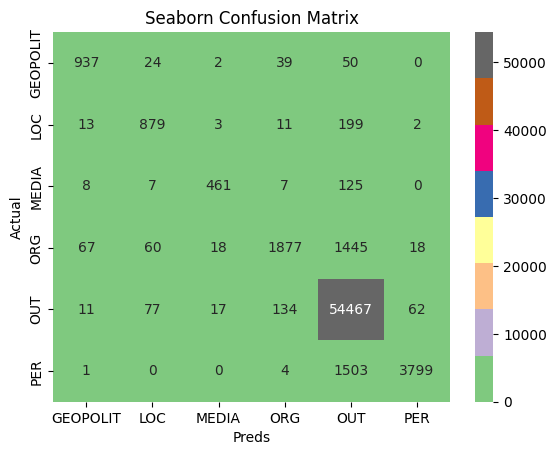

In [59]:
preds_bi = mmodel_bi.predict(valid_x)
preds_bi = np.argmax(preds_bi,axis=1)

print(classification_report(valid_y, preds_bi))

cm = confusion_matrix(valid_y, preds_bi)
ax = sns.heatmap(cm, annot=True, fmt='g', cmap="Accent")

ax.set_title('Seaborn Confusion Matrix')
ax.set_xlabel('Preds')
ax.set_ylabel('Actual')

## For the Tick Labels, the labels should be in Alphabetical order
ax.xaxis.set_ticklabels(['GEOPOLIT', 'LOC', 'MEDIA', 'ORG', 'OUT', 'PER'])
ax.yaxis.set_ticklabels(['GEOPOLIT', 'LOC', 'MEDIA', 'ORG', 'OUT', 'PER'])

plt.show()

In [60]:
# добавим биграмы и триграмы и длину последовательности 100
seq_len = 100

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    ngrams=(1, 3),
    output_sequence_length=seq_len)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_data = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_data)
mmodel_three = modelNER()
mmodel_three.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

mmodel_three.fit( train_data, validation_data=valid_data, epochs=3)

Epoch 1/3
12437/12437 [==============================] - 85s 7ms/step - loss: 0.2941 - accuracy: 0.9145 - val_loss: 0.2116 - val_accuracy: 0.9373
Epoch 2/3
12437/12437 [==============================] - 82s 7ms/step - loss: 0.1249 - accuracy: 0.9627 - val_loss: 0.2079 - val_accuracy: 0.9397
Epoch 3/3
12437/12437 [==============================] - 90s 7ms/step - loss: 0.1091 - accuracy: 0.9658 - val_loss: 0.2524 - val_accuracy: 0.8948


2073/2073 [==============================] - 8s 4ms/step
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1052
           1       0.83      0.79      0.81      1107
           2       0.92      0.76      0.83       608
           3       0.90      0.52      0.66      3485
           4       0.96      0.92      0.94     54768
           5       0.50      0.89      0.64      5307

    accuracy                           0.89     66327
   macro avg       0.84      0.80      0.80     66327
weighted avg       0.92      0.89      0.90     66327



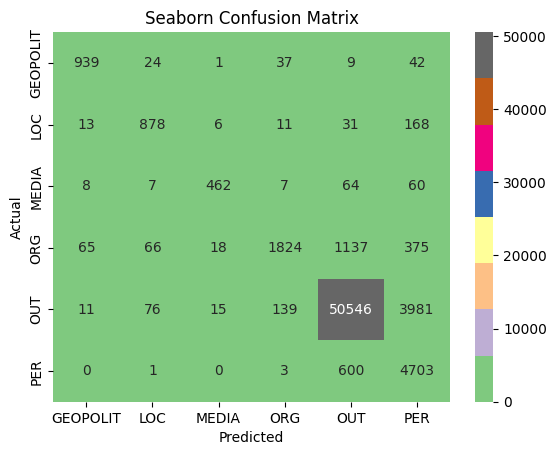

In [61]:
preds_three = mmodel_three.predict(valid_x)
preds_three = np.argmax(preds_three,axis=1)

print(classification_report(valid_y, preds_three))

cm = confusion_matrix(valid_y, preds_three)
ax = sns.heatmap(cm, annot=True, fmt='g', cmap="Accent")

ax.set_title('Seaborn Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

## For the Tick Labels, the labels should be in Alphabetical order
ax.xaxis.set_ticklabels(['GEOPOLIT', 'LOC', 'MEDIA', 'ORG', 'OUT', 'PER'])
ax.yaxis.set_ticklabels(['GEOPOLIT', 'LOC', 'MEDIA', 'ORG', 'OUT', 'PER'])

plt.show()